# Comparing existing and new links

Dominika Tkaczyk

22.11.2018

In this analysis I examine how the links existing in the live system compare to the links currently returned by STQ and SBM(V) algorithms.

The results from this notebook were published on [Crossref blog](https://www.crossref.org/blog/reference-matching-for-real-this-time/).

For the comparison of the algorithms on automatically generated reference strings, see [this notebook](https://github.com/CrossRef/reference-matching-evaluation/blob/master/analyses/blog/comparison.ipynb).

## TL;DR

  * The dataset used in this analysis is composed of 2000 random reference strings from the live system. For each string I have:
    * original link (currently in the system)
    * STQ link (the link returned by STQ form)
    * SBM link (the link returned by SBM algorithm)
    * SBMV link (the link returned by SBMV algorithm)
  * Both variations of SBM are outperformed by STQ (F1 92.5% vs. 84.3% and 83.6%).
  * **SBMV outperforms STQ (F1 96.3% vs. 92.5%)**, with precision worse by 0.86 percentage points and recall better by 7.71 percentage points. The difference in precision between SBMV and STQ is not statistically significant. The difference in recall between SBMV and STQ is statistically significant.
  * SBMV also outperforms the results for the current links (F1 96.3% vs. 77.8%). Applying SBMV to currently not resolved links would result in 51.4% more links, 95.5% of which would be correct.
  * There is a high level of agreement between the links (original vs. STQ vs. SBMV):
    * in 84.7% of the cases SBM with a simple threshold link is equal to either original or new STQ link
    * in 78.0% of the cases SBM with a normalized threshold link is equal to either original or new STQ link
    * in 94.0% of the cases SBMV link is equal to either original or new STQ link

## Methodology

The goal of this analysis is to examine the agreement between the approaches, as well as to estimate precision, recall and F1 on the real data.

The following procedure was used to gather the data for these experiments:
1. A random sample of 100K items was extracted from the system.
2. I iterated over all references in the sampled items, and extracted all unstructured references (reference strings).
3. I sampled 2000 unstructured references from them, recorded the existing target DOI (if any), and ran STQ, SBM and SBMV algorithms on them.
4. I manually provided ground truth target DOIs for each reference string. This was done by verifying DOIs returned by the algorithms and/or manual searching.

## Results

In [1]:
import sys
sys.path.append('../..')

%matplotlib inline

import json
import matplotlib.pyplot as plt
import numpy as np
import re
import utils.data_format_keys as dfk

from dataset.dataset_utils import get_target_gt_doi, get_target_test_doi
from evaluation.evaluation_utils import doi_test_same, doi_equals
from evaluation.link_metrics import LinkMetricsResults
from evaluation.reference_metrics import ReferenceMetricsResults
from scipy.stats import chi2_contingency
from utils.utils import read_json

DATA_DIR = '../../data/blog/existing_links/'

### Precision, recall, F1

First, let's compare precision, recall and F1 of different algorithms.

Here are the results of the links currently present in the system:

In [2]:
def print_summary(dataset, name):
    link_results = LinkMetricsResults(dataset)
    print('{} precision: {:.4f} (CI at 95% {:.4f}-{:.4f})'
          .format(name, link_results.get(dfk.EVAL_PREC),
                  link_results.get(dfk.EVAL_CI_PREC)[0], link_results.get(dfk.EVAL_CI_PREC)[1]))
    print('{} recall: {:.4f} (CI at 95% {:.4f}-{:.4f})'
          .format(name, link_results.get(dfk.EVAL_REC),
                  link_results.get(dfk.EVAL_CI_REC)[0], link_results.get(dfk.EVAL_CI_REC)[1]))
    print('{} F1: {:.4f}'.format(name, link_results.get(dfk.EVAL_F1)))

dataset_orig = read_json(DATA_DIR + 'unstructured_orig.json')[dfk.DATASET_DATASET]
print_summary(dataset_orig, 'original')

original precision: 0.9922 (CI at 95% 0.9860-0.9984)
original recall: 0.6399 (CI at 95% 0.6126-0.6671)
original F1: 0.7780


For precision and recall the confidence intervals at the confidence level of 95% are given. The confidence interval is the range of values where the real value is likely to be. For example, based on this, we are 95% sure that the real recall in the system currently is in the range 0.6126-0.6671. More information about the foundations of sampling and confidence intervals can be found in [this notebook](https://github.com/CrossRef/reference-matching-evaluation/blob/master/analyses/sampling_notes.ipynb).

Here are the results of STQ:

In [3]:
dataset_stq = read_json(DATA_DIR + 'unstructured_stq.json')[dfk.DATASET_DATASET]
print_summary(dataset_stq, 'STQ')

STQ precision: 0.9895 (CI at 95% 0.9833-0.9957)
STQ recall: 0.8685 (CI at 95% 0.8493-0.8877)
STQ F1: 0.9251


In order to calculate the results for SBM and SBMV, we have to modify the SBM and SBMV datasets according to the best thresholds calculated previously. These functions will modify the dataset according to the simple, normalized or validation threshold:

In [4]:
def modify_simple_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def modify_norm_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None \
            and item[dfk.DATASET_SCORE]/len(item[dfk.DATASET_REF_STRING]) < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

def modify_valid_threshold(dataset, threshold):
    for item in dataset:
        if item[dfk.DATASET_SCORE] is not None and item[dfk.DATASET_SCORE] < threshold:
            item[dfk.DATASET_TARGET_TEST][dfk.CR_ITEM_DOI] = None
    return dataset

Let's see the results of SBM with a simple threshold of 64:

In [5]:
dataset_sbm_simple = read_json(DATA_DIR + 'unstructured_sbm.json')[dfk.DATASET_DATASET]
modify_simple_threshold(dataset_sbm_simple, 64)
print_summary(dataset_sbm_simple, 'SBM')

SBM precision: 0.8686 (CI at 95% 0.8488-0.8883)
SBM recall: 0.8191 (CI at 95% 0.7973-0.8409)
SBM F1: 0.8431


Now the results of SBM with the normalized threshold of 0.4:

In [6]:
dataset_sbm_norm = read_json(DATA_DIR + 'unstructured_sbm.json')[dfk.DATASET_DATASET]
modify_norm_threshold(dataset_sbm_norm, 0.4)
print_summary(dataset_sbm_norm, 'SBM')

SBM precision: 0.7712 (CI at 95% 0.7493-0.7932)
SBM recall: 0.9121 (CI at 95% 0.8960-0.9281)
SBM F1: 0.8358


And finally, the results of SBMV with the validation threshold of 0.34:

In [7]:
dataset_sbmv = read_json(DATA_DIR + 'unstructured_sbmv.json')[dfk.DATASET_DATASET]
modify_simple_threshold(dataset_sbmv, 0.34) 
print_summary(dataset_sbmv, 'SBMV')

SBMV precision: 0.9809 (CI at 95% 0.9730-0.9888)
SBMV recall: 0.9456 (CI at 95% 0.9327-0.9584)
SBMV F1: 0.9629


Let's compare all the results in one plot:

In [8]:
def get_means(dataset):
    results = LinkMetricsResults(dataset)
    return [results.get(m) for m in [dfk.EVAL_PREC, dfk.EVAL_REC, dfk.EVAL_F1]]

def get_ci(dataset):
    results = LinkMetricsResults(dataset)
    ms = [results.get(m) for m in [dfk.EVAL_PREC, dfk.EVAL_REC]]
    return [[a-results.get(m)[0] for m, a in zip([dfk.EVAL_CI_PREC, dfk.EVAL_CI_REC], ms)] + [0],
            [results.get(m)[1]-a for m, a in zip([dfk.EVAL_CI_PREC, dfk.EVAL_CI_REC], ms)] + [0]]

def autolabel(ax, rects):
    plt.rcParams.update({'font.size': 10})
    for rect in rects:
        height = rect.get_height()
        text = '{:.2f}'.format(height)
        text = re.sub('\.00$', '', text)
        ax.text(rect.get_x() + rect.get_width()/2., 1.03*height, text, ha='center', va='bottom')

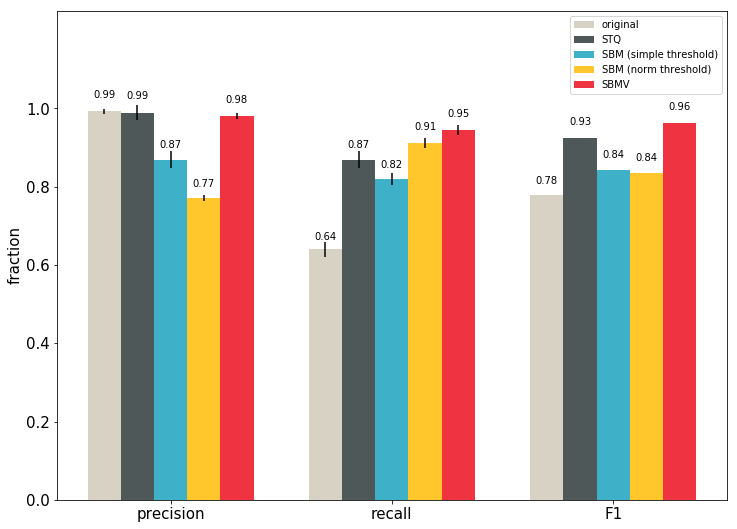

In [9]:
ind = np.arange(3)
width = 0.15
plt.rcParams.update({'font.size': 15, 'legend.fontsize': 10}) 
fig, ax = plt.subplots(figsize=(12, 9))

rects1 = ax.bar(ind - 1.5 * width, get_means(dataset_orig), yerr=get_ci(dataset_stq), width=width,
                color='#d8d2c4')
rects2 = ax.bar(ind - 0.5 * width, get_means(dataset_stq), yerr=get_ci(dataset_sbm_simple),
                width=width, color='#4f5858')
rects3 = ax.bar(ind + 0.5 * width, get_means(dataset_sbm_simple), yerr=get_ci(dataset_sbm_norm),
                width=width, color='#3eb1c8')
rects4 = ax.bar(ind + 1.5 * width, get_means(dataset_sbm_norm), yerr=get_ci(dataset_sbmv),
                width=width, color='#ffc72c')
rects5 = ax.bar(ind + 2.5 * width, get_means(dataset_sbmv), yerr=get_ci(dataset_sbmv),
                width=width, color='#ef3340')

ax.set_ylabel('fraction')
ax.set_xticks(ind + width / 2)
ax.set_xticklabels(('precision', 'recall', 'F1'))
plt.ylim(0, 1.25)
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.legend((rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]),
          ('original', 'STQ', 'SBM (simple threshold)', 'SBM (norm threshold)', 'SBMV'))
autolabel(ax, rects1)
autolabel(ax, rects2)
autolabel(ax, rects3)
autolabel(ax, rects4)
autolabel(ax, rects5)

plt.show() 

As we can see, SBMV outperforms all other algorithms. It is better than STQ (F1 96.29% vs. 92.51%), with precision worse by only 0.86 percentage points and recall better by 7.71 percentage points.

Both variations of SBM are much worse than SBMV and STQ.

Let's also calculate statistical significance between STQ's and SBMV's precision and recall using a Chi-square test of independence:

In [10]:
for metric in [dfk.EVAL_PREC, dfk.EVAL_REC]:
    fun = get_target_test_doi if metric == dfk.EVAL_PREC else get_target_gt_doi
    stq_results = LinkMetricsResults(dataset_stq)
    stq_precision = stq_results.get(metric)
    stq_test_count = len([d for d in dataset_stq if fun(d) is not None])
    stq_precision_success = int(stq_precision * stq_test_count)

    sbmv_results = LinkMetricsResults(dataset_sbmv)
    sbmv_precision = sbmv_results.get(metric)
    sbmv_test_count = len([d for d in dataset_sbmv if fun(d) is not None])
    sbmv_precision_success = int(sbmv_precision * sbmv_test_count)

    _, p, _, _ = chi2_contingency(np.array([[stq_precision_success,
                                             stq_test_count-stq_precision_success],
                                           [sbmv_precision_success,
                                            sbmv_test_count-sbmv_precision_success]]),
                                  correction=True)
    c = 'this is statistically significant' if p < 0.05 \
        else 'this is not statistically significant'
    print('{} p-value: {:.4f} ({})'.format(metric, p, c))

precision p-value: 0.1377 (this is not statistically significant)
recall p-value: 0.0000 (this is statistically significant)


The difference in precision is not statistically significant. In other words, the values are so close that we cannot rule out that the difference is due to the randomness in sampling.

The difference in recall is statistically significant.

Let's also see what would the validation threshold of SBMV be if we wanted to match STQ's precision:

In [11]:
dataset_sbmv = read_json(DATA_DIR + 'unstructured_sbmv.json')[dfk.DATASET_DATASET]
results = [LinkMetricsResults(modify_simple_threshold(dataset_sbmv, t))
           for t in np.arange(0, 1, 0.01)]
thresholds = np.arange(0, 1, 0.1)
precisions = [r.get(dfk.EVAL_PREC) for r in results]
recalls = [r.get(dfk.EVAL_REC) for r in results]
for i, p in enumerate(precisions):
    if p >= 0.9895:
        break
print('STQ\'s precision is matched for threshold {}'.format(i/100))
print('Recall for this threshold: {}'.format(recalls[i]))

STQ's precision is matched for threshold 0.43
Recall for this threshold: 0.9321608040201005


For the threshold 0.43 the recall is 93.2%, which is still higher than STQ's recall of 86.9%.

Finally, let's see how many more links we would get if we applied SBMV to currently unresolved references in the system:

In [12]:
dataset_sbmv = read_json(DATA_DIR + 'unstructured_sbmv.json')[dfk.DATASET_DATASET]
modify_simple_threshold(dataset_sbmv, 0.34) 

orig_links = len([d for d in dataset_orig if get_target_test_doi(d) is not None])
sbmv_new_links = len([d_sbmv for d_orig, d_sbmv in zip(dataset_orig, dataset_sbmv)
                      if get_target_test_doi(d_sbmv) is not None
                      and get_target_test_doi(d_orig) is None])
sbmv_new_correct_links = len([d_sbmv for d_orig, d_sbmv in zip(dataset_orig, dataset_sbmv)
                              if get_target_test_doi(d_sbmv) is not None
                              and get_target_test_doi(d_orig) is None
                              and doi_equals(d_sbmv)])

print('Applying SBMV to currently not resolved links will result in {:.2f}% more links'
      .format(100*sbmv_new_links/orig_links))
print('{:.2f}% of the new links will be correct'
      .format(100*sbmv_new_correct_links/sbmv_new_links))

Applying SBMV to currently not resolved links will result in 51.43% more links
95.45% of the new links will be correct


### Agreement between links

Let's also see what is the agreement between the links.

Function *get_category* classifies an item from the dataset into one of the categories:
  * SBM(V) = STQ = orig (all links agree)
  * SBM(V) = STQ =/= orig (original link is different)
  * SBM(V) = orig =/= STQ (new STQ link is different)
  * SBM(V) =/= STQ = orig (SBM(V) link is different)
  * other

In [13]:
categories = ['SBM(V) = STQ = orig', 'SBM(V) = STQ =/= orig', 'SBM(V) = orig =/= STQ',
              'SBM(V) =/= STQ = orig', 'other']

def get_category(item_orig, item_stq, item_new):
    if doi_test_same(item_orig, get_target_test_doi(item_stq)) and \
            doi_test_same(item_orig, get_target_test_doi(item_new)):
        return 'SBM(V) = STQ = orig'
    if doi_equals(item_orig) and doi_equals(item_stq) and doi_equals(item_new):
        return 'SBM(V) = STQ = orig'
    if doi_test_same(item_new, get_target_test_doi(item_stq)) and \
            not doi_test_same(item_new, get_target_test_doi(item_orig)):
        return 'SBM(V) = STQ =/= orig'
    if not doi_equals(item_orig) and doi_equals(item_stq) and doi_equals(item_new):
        return 'SBM(V) = STQ =/= orig'
    if doi_test_same(item_new, get_target_test_doi(item_orig)) and \
            not doi_test_same(item_new, get_target_test_doi(item_stq)):
        return 'SBM(V) = orig =/= STQ'
    if doi_equals(item_orig) and not doi_equals(item_stq) and doi_equals(item_new):
        return 'SBM(V) = orig =/= STQ'
    if doi_test_same(item_stq, get_target_test_doi(item_orig)) and \
            not doi_test_same(item_new, get_target_test_doi(item_stq)):
        return 'SBM(V) =/= STQ = orig'
    if doi_equals(item_orig) and doi_equals(item_stq) and not doi_equals(item_new):
        return 'SBM(V) =/= STQ = orig'
    return 'other'

What is the distribution of the categories in the dataset for the best simple threshold of SBM?

In [14]:
dataset_orig = read_json(DATA_DIR + 'unstructured_orig.json')[dfk.DATASET_DATASET]
dataset_stq = read_json(DATA_DIR + 'unstructured_stq.json')[dfk.DATASET_DATASET]
dataset_sbm = read_json(DATA_DIR + 'unstructured_sbm.json')[dfk.DATASET_DATASET]
modify_simple_threshold(dataset_sbm, 64)

data_categories = [get_category(d1, d2, d3)
                   for d1, d2, d3 in zip(dataset_orig, dataset_stq, dataset_sbm)]
categories_counts = {cat: data_categories.count(cat)/len(data_categories) for cat in categories}
categories_counts

{'SBM(V) = STQ = orig': 0.684,
 'SBM(V) = STQ =/= orig': 0.122,
 'SBM(V) = orig =/= STQ': 0.0405,
 'SBM(V) =/= STQ = orig': 0.1475,
 'other': 0.006}

In 68.4% of the cases all links agree and in 84.65% SBM link is equal to either original or STQ link.

What about the distribution of the categories in the dataset for the best normalized threshold of SBM?

In [15]:
dataset_orig = read_json(DATA_DIR + 'unstructured_orig.json')[dfk.DATASET_DATASET]
dataset_stq = read_json(DATA_DIR + 'unstructured_stq.json')[dfk.DATASET_DATASET]
dataset_sbm = read_json(DATA_DIR + 'unstructured_sbm.json')[dfk.DATASET_DATASET]
modify_norm_threshold(dataset_sbm, 0.4)

data_categories = [get_category(d1, d2, d3)
                   for d1, d2, d3 in zip(dataset_orig, dataset_stq, dataset_sbm)]
categories_counts = {cat: data_categories.count(cat)/len(data_categories) for cat in categories}
categories_counts

{'SBM(V) = STQ = orig': 0.6215,
 'SBM(V) = STQ =/= orig': 0.1435,
 'SBM(V) = orig =/= STQ': 0.0145,
 'SBM(V) =/= STQ = orig': 0.21,
 'other': 0.0105}

In 62.15% of the cases all links agree and in 77.95% SBM link is equal to either original or STQ link.

What about the distribution of the categories in the dataset for the best validation threshold of SBMV?

In [16]:
dataset_orig = read_json(DATA_DIR + 'unstructured_orig.json')[dfk.DATASET_DATASET]
dataset_stq = read_json(DATA_DIR + 'unstructured_stq.json')[dfk.DATASET_DATASET]
dataset_sbmv = read_json(DATA_DIR + 'unstructured_sbmv.json')[dfk.DATASET_DATASET]
modify_simple_threshold(dataset_sbmv, 0.34)

data_categories = [get_category(d1, d2, d3)
                   for d1, d2, d3 in zip(dataset_orig, dataset_stq, dataset_sbmv)]
categories_counts = {cat: data_categories.count(cat)/len(data_categories) for cat in categories}
categories_counts

{'SBM(V) = STQ = orig': 0.773,
 'SBM(V) = STQ =/= orig': 0.148,
 'SBM(V) = orig =/= STQ': 0.019,
 'SBM(V) =/= STQ = orig': 0.0585,
 'other': 0.0015}

In 77.3% of the cases all links agree and in 94.0% SBMV link is equal to either original or STQ link.

### Error analysis

Let's also look more closely at the causes of SBMV errors in our 2000 references.

In [17]:
data = read_json(DATA_DIR + 'comparison-reasons.json')
sbm_link = 'search_API_link'
sbm_score = 'search_API_score'
gt_link = 'gt'
res = [d.update({sbm_link: None}) for d in data
       if d[sbm_score] is not None and d[sbm_score] < 0.34]
print('Dataset size: {}'.format(len(data)))

Dataset size: 2000


How many references were correctly matched?

In [18]:
data_correct_res = [d for d in data if d[sbm_link] == d[gt_link] and d[sbm_link] is not None]
print('Correctly resolved references: {} ({:.2f}%)'.format(len(data_correct_res),
                                                           100*len(data_correct_res)/len(data)))

Correctly resolved references: 1129 (56.45%)


How many references were correctly not matched to anything?

In [19]:
data_correct_not_res = [d for d in data if d[sbm_link] == d[gt_link] and d[sbm_link] is None]
print('Correctly not resolved references: {} ({:.2f}%)'
      .format(len(data_correct_not_res), 100*len(data_correct_not_res)/len(data)))

Correctly not resolved references: 791 (39.55%)


We are left with 80 reference strings incorrectly matched or unmatched.

How many references are matched to the wrong document?

In [20]:
data_incorrect_res = [d for d in data if d[sbm_link] != d[gt_link] and d[sbm_link] is not None
                      and d[gt_link] is not None]
print('References resolved to the wrong document: {} ({:.2f}%)'
      .format(len(data_incorrect_res), 100*len(data_incorrect_res)/len(data)))

References resolved to the wrong document: 7 (0.35%)


Let's see the summary of the causes of these errors:

In [21]:
def summarize_causes(data):
    causes = [d['reason'] for d in data]
    causes = list(set([(r, causes.count(r)) for r in causes]))
    causes.sort(key=lambda x: x[1], reverse=True) 
    return causes

summarize_causes(data_incorrect_res)

[('similar metadata', 2),
 ('no title in the ref string', 2),
 ('two similar papers differ by journal name only', 1),
 ('search score too low to be considered as a candidate', 1),
 ('chapter matched instead of the book', 1)]

We have only 7 cases. In two cases the mistake was caused by missing title in the reference string. In one case the right target's relevance score was too low, and the remaining four reference strings were matched to similar documents.

How many missing links we have?

In [22]:
data_incorrect_not_res = [d for d in data if d[sbm_link] is None and d[gt_link] is not None]
print('Missing links: {} ({:.2f}%)'
      .format(len(data_incorrect_not_res), 100*len(data_incorrect_not_res)/len(data)))

Missing links: 58 (2.90%)


This is the largest category of the errors. What were the causes?

In [23]:
summarize_causes(data_incorrect_not_res)

[('missing author in the metadata', 8),
 ('search score too low to be considered as a candidate', 7),
 ('missing year in the metadata', 7),
 ('year mismatch', 5),
 ('missing year and pages in the metadata', 4),
 ('DOI resolvable but not visible in API', 4),
 ('missing author in the ref string', 4),
 ('no numbers in the ref string except for arXiv id', 4),
 ('search score too low to be considered as a candidate; no title in the ref string',
  3),
 ('missing title in the metadata', 2),
 ('missing title in the ref string', 2),
 ('ref string contains a large HTML fragment', 2),
 ('no title or numbers in the ref string', 1),
 ("author's entire name as family name in the metadata, ref string contains abbreviated first name",
  1),
 ('missing year in the ref string', 1),
 ('matcher error', 1),
 ('title given in different language in the ref string', 1),
 ('missing author in the ref string, missing year in the metadata', 1)]

The most common causes are:
  * the target was scored too low by the search engine
  * missing metadata in the items in the system
  * missing information in the reference strings
  
Finally, how many unexpected links we have?

In [24]:
data_incorrect_extra_res = [d for d in data if d[sbm_link] is not None and d[gt_link] is None]
print('Incorrect extra links: {} ({:.2f}%)'
      .format(len(data_incorrect_extra_res), 100*len(data_incorrect_extra_res)/len(data)))

Incorrect extra links: 15 (0.75%)


We have 15 extra links. What were the causes?

In [25]:
summarize_causes(data_incorrect_extra_res)

[('multiple references in the string', 6),
 ('similar metadata', 4),
 ('journal article matched; chapter/book referenced', 2),
 ('different versions of the paper', 1),
 ('conference paper matched; phd thesis referenced', 1),
 ('journal article matched; working paper referenced', 1)]

The most common cases are:
  * Sometimes the reference string contains multiple references, either intentionally or by mistake. In such cases we expect the matching algorithm not to return any match, but sometimes the match is found.
  * Reference strings containing similar metadata as the matched items, while the referenced version of the document is not present in the system.